In [ ]:
from imports import *
from exactDiagMethods import perform_exact_diag, build_exact_diag_hamiltonian
from globalMethods import  build_initial_states, output_results
from vqteMethods import hamiltonian_generation, perform_vqte

In [2]:

def main():
    # Initialize the simulation parameters
    N = 3
    gamma=0.05
    eps=1
    mu_L=2
    mu_R=0.1
    T_L = 4
    T_R= 5
    beta_L=1/T_L
    beta_R=1/T_R
    F_L = 1/(np.exp(beta_L*(eps-mu_L))+1)
    F_R = 1/(np.exp(beta_R*(eps-mu_R))+1)
    J = 1

    time = 3.0
    dt = 0.1
    nt = int(time/dt)
    exact_diag_ham= build_exact_diag_hamiltonian(N)


    ham_real, ham_imag = hamiltonian_generation(N, J, eps, gamma, F_L, F_R)
    print("Ham imag", ham_imag)
    print("Ham real", ham_real)

    vqte_init_state, exact_diag_init_state, ansatz, init_param_values = build_initial_states(ham_real, N)

    print("VQTE initial state", vqte_init_state)
    print("Exact initial state:",exact_diag_init_state)

    # # Perform exact diagonalization
    exact_diag_results, time_points = perform_exact_diag(gamma, F_L, F_R, dt, nt, exact_diag_init_state,exact_diag_ham,N,eps)


    # # Perform VQTE simulation
    vqte_results = perform_vqte(ham_real, ham_imag, vqte_init_state, dt, nt, ansatz, init_param_values,N)
    # #Example VQE
    # # Output results
    #output_exact_diag_results(exact_diag_results, time, nt, eps, mu_L,mu_R,T_L, T_R, time_points)
    output_results(vqte_results, exact_diag_results, time, nt, time_points)

Ham imag SparsePauliOp(['III', 'ZII', 'IIZ'],
              coeffs=[-0.025     +0.j, -0.00310883+0.j,  0.00224394+0.j])
Ham real SparsePauliOp(['ZII', 'IZI', 'IIZ', 'XXI', 'YYI', 'IXX', 'IYY'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])
VQTE initial state Statevector([ 1.00000000e+00+7.34788079e-16j,
             -1.22464680e-16-5.99903913e-32j,
             -1.22464680e-16-5.99903913e-32j,
             -1.22464680e-16+2.73691106e-48j,
             -2.44929360e-16-8.99855870e-32j,
              4.49927935e-32-1.21543267e-63j,
             -1.22464680e-16+0.00000000e+00j,
              4.49927935e-32-1.46934081e-47j],
            dims=(2, 2, 2))
Exact initial state: [[ 1.00000000e+00+0.00000000e+00j -1.22464680e-16-2.99951957e-32j
  -1.22464680e-16-2.99951957e-32j -1.22464680e-16-8.99855870e-32j
  -2.44929360e-16-8.99855870e-32j  4.49927935e-32+3.30601683e-47j
  -1.22464680e-16-8.99855870e-32j  4.49927935e-32+4.77535765e-47j]
 [-1.22464680e-16+2.99951

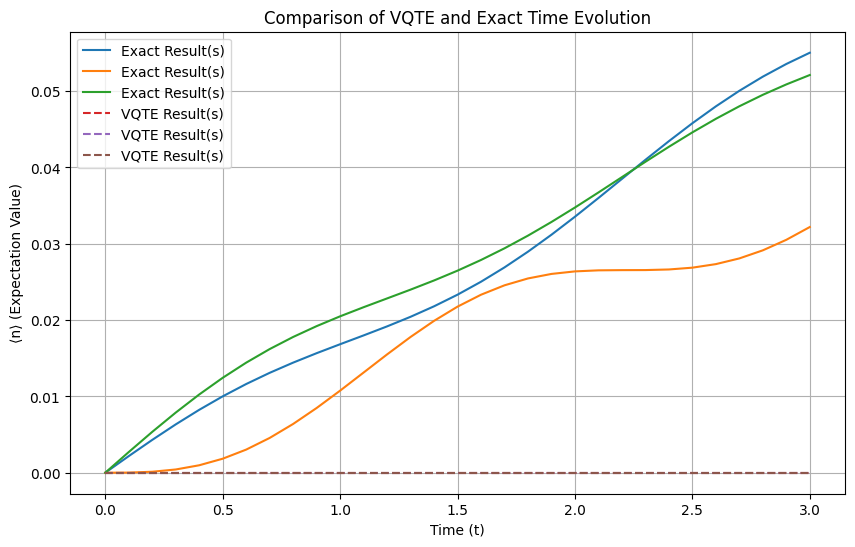

In [3]:
main()